# Load Modules

In [1]:
# Modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import (confusion_matrix, auc, classification_report, dcg_score, f1_score, precision_recall_curve,\
                             precision_score, recall_score, roc_auc_score, roc_curve)
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

import pycaret
import pandas_profiling
import matplotlib.pyplot as plt
import itertools

import pickle
import joblib
import math
import os

from pygam import LogisticGAM, s, f
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix, without normalization')
    plt.show()

    # Plot normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True, title='Normalized confusion matrix')
    plt.show()

def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    # fi to dataframe
#     df = pd.DataFrame(data=[model.feature_importances_, model.feature_name_], index=['importance','feature']).T
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [96]:
def classification_result(df, y_true, y_pred):
    conditionlist = [
        (df['y_true']==1) & (df['y_pred']==1),
        (df['y_true']==0) & (df['y_pred']==0),
        (df['y_true']==0) & (df['y_pred']==1),
        (df['y_true']==1) & (df['y_pred']==0)]
    
    choicelist = ['TP', 'TN', 'FP', 'FN']
    
    df['class'] = np.select(conditionlist, choicelist, default='Not Specified')
    
    return df

In [4]:
print(os.listdir('../../../data/santander/raw/'))

['original_test.pickle', 'original_train.pickle', 'test.csv', 'train.csv']


# Load Data

In [5]:
# path = '../Digitallab_Project/what_if/data/santander'
path = '../../../data/santander'
df_train = pd.read_pickle(path + '/raw/original_train.pickle')
df_test = pd.read_pickle(path + '/raw/original_test.pickle')

In [6]:
df_train.sample(3)

ID_code  target      var_0     var_1      var_2     var_3  \
10397    train_10397       0   4.792969 -1.318359  11.203125  4.804688   
168711  train_168711       0   4.835938  2.681641  10.476562  5.941406   
4583      train_4583       0  10.031250 -4.507812   9.179688  7.261719   

            var_4     var_5     var_6      var_7  ...   var_190    var_191  \
10397    9.117188 -2.716797  5.363281  20.046875  ...  2.748047  12.015625   
168711  11.609375 -3.267578  6.378906  22.312500  ...  6.882812   7.996094   
4583     9.125000 -9.398438  6.660156  22.968750  ...  1.028320   9.273438   

         var_192   var_193    var_194   var_195   var_196   var_197  \
10397   3.324219  1.981445  15.585938  2.169922 -5.015625  8.289062   
168711  3.564453  3.441406  21.515625  1.905273  7.628906  8.085938   
4583    3.269531  8.500000  19.093750  0.710938  2.566406  8.820312   

          var_198    var_199  
10397   13.828125 -10.093750  
168711  14.367188  -7.382812  
4583    16.546875  -2.933594  

[3 rows x 202 columns]

In [8]:
df_train.shape

(200000, 202)

# EBM Modeling

## Prepare dataset for modeling

In [7]:
X = df_train.drop(['ID_code', 'target'], axis=1)
y = df_train['target']

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)
print('train : ', X_train.shape, '\t', 'test : ', X_valid.shape)

train :  (140000, 200) 	 test :  (60000, 200)


## Train

In [9]:
# Load Modules for EBM
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
from interpret.data import ClassHistogram

In [17]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

ExplainableBoostingClassifier(feature_names=['var_0', 'var_1', 'var_2', 'var_3',
                                             'var_4', 'var_5', 'var_6', 'var_7',
                                             'var_8', 'var_9', 'var_10',
                                             'var_11', 'var_12', 'var_13',
                                             'var_14', 'var_15', 'var_16',
                                             'var_17', 'var_18', 'var_19',
                                             'var_20', 'var_21', 'var_22',
                                             'var_23', 'var_24', 'var_25',
                                             'var_26', 'var_27', 'var_28',
                                             'var_29', ...],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                   

In [18]:
joblib.dump(ebm,'01_05_ebm_org_data.pkl')

['01_05_ebm_org_data.pkl']

In [10]:
ebm = joblib.load('01_05_ebm_org_data.pkl')

## Predict

In [14]:
# Predict train set
y_pred_tr = ebm.predict(X_train)
y_score_tr = ebm.predict_proba(X_train)

In [15]:
# Predict Valid set
y_pred = ebm.predict(X_valid)
y_score = ebm.predict_proba(X_valid)

In [16]:
# df for result 
y_score_tr = pd.DataFrame(data=y_score_tr).rename({0:'y_proba_0', 1:'y_proba_1'}, axis=1)
y_true_tr = pd.DataFrame(data=y_train).reset_index(drop=True).rename({'target':'y_true'}, axis=1)
y_pred_tr = pd.DataFrame(data=y_pred_tr).rename({0:'y_pred'}, axis=1)
df_pred_tr_summary = pd.concat([y_score_tr,y_true_tr,y_pred_tr], axis=1)

y_score = pd.DataFrame(data=y_score).rename({0:'y_proba_0', 1:'y_proba_1'}, axis=1)
y_true = pd.DataFrame(data=y_valid).reset_index(drop=True).rename({'target':'y_true'}, axis=1)
y_pred = pd.DataFrame(data=y_pred).rename({0:'y_pred'}, axis=1)
df_pred_summary = pd.concat([y_score,y_true,y_pred], axis=1)

In [17]:
len(df_pred_tr_summary)

140000

In [18]:
df_pred_summary.head(3)

y_proba_0  y_proba_1  y_true  y_pred
0   0.998229   0.001771       0       0
1   0.952123   0.047877       0       0
2   0.959802   0.040198       0       0

# Evaluation

In [81]:
# ROC_AUC
print('AUC of Train set : ', '{:.3}'.format(roc_auc_score(df_pred_tr_summary['y_true'],df_pred_tr_summary['y_proba_1'])))
print('AUC of Test  set : ', '{:.3}'.format(roc_auc_score(df_pred_summary['y_true'],df_pred_summary['y_proba_1'])))

AUC of Train set :  0.921
AUC of Test  set :  0.899


In [29]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     53971
           1       0.78      0.35      0.48      6029

    accuracy                           0.92     60000
   macro avg       0.85      0.67      0.72     60000
weighted avg       0.92      0.92      0.91     60000



Confusion matrix, without normalization


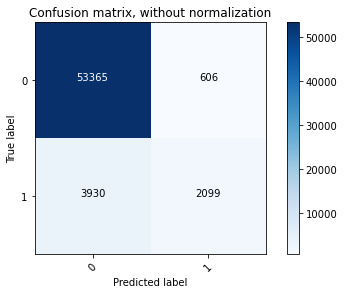

Normalized confusion matrix


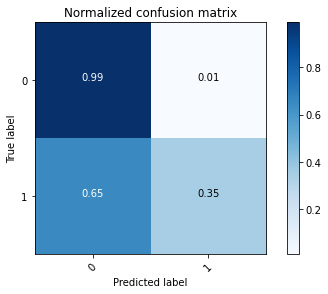

In [28]:
plot_confusion_matrix(y_pred, y_valid)

In [66]:
df_pred_tr_summary=classification_result(df_pred_tr_summary, y_true_tr, y_pred_tr)
df_pred_summary=classification_result(df_pred_summary, y_true, y_pred)

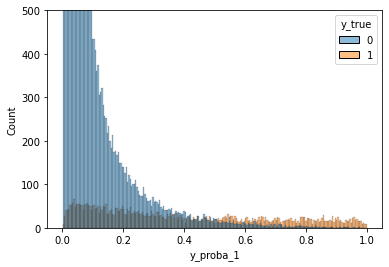

In [74]:
# Distribution of prediction
sns.histplot(data=df_pred_summary, x='y_proba_1', hue='y_true')
plt.ylim(0,500)
plt.show()

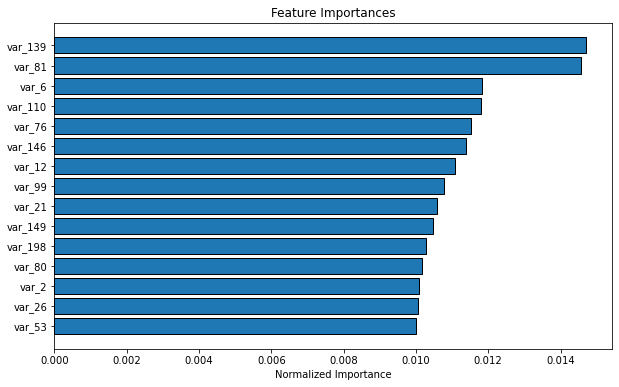

index           feature  importance  importance_normalized
0      139           var_139    0.176795               0.014701
1       81            var_81    0.175144               0.014564
2        6             var_6    0.142383               0.011839
3      110           var_110    0.141768               0.011788
4       76            var_76    0.138418               0.011510
..     ...               ...         ...                    ...
205      7             var_7    0.010204               0.000848
206    201  var_81 x var_184    0.008366               0.000696
207    202   var_40 x var_78    0.008332               0.000693
208     96            var_96    0.008291               0.000689
209    203  var_81 x var_164    0.006856               0.000570

[210 rows x 4 columns]

In [117]:
plot_feature_importances(df_feature_importance)

# Interpret

In [11]:
# ebm.feature_importance_ 결과와 동일
ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/2734712536464/ -->

In [12]:
ebm_local = ebm.explain_local(X_valid, y_valid)
show(ebm_local)

<!-- http://127.0.0.1:7001/2735183761216/ -->

In [19]:
# ebm_local_smp = ebm.explain_local(X_valid[:5], y_valid[:5])
# show(ebm_local_smp)

# Make Dataframes for visualization

## Global Feature Importance

In [89]:
df_feature_importance = pd.DataFrame(data=[ebm.feature_names, ebm.feature_importances_], index=['feature','importance']).T
    
# Sort features according to importance
df_feature_importance = df_feature_importance.sort_values('importance', ascending = False)

# Normalize the feature importances to add up to one
df_feature_importance['importance_normalized'] = df_feature_importance['importance'] / df_feature_importance['importance'].sum()
df_feature_importance.head(3)

feature importance importance_normalized
139  var_139   0.176795             0.0147007
81    var_81   0.175144             0.0145635
6      var_6   0.142383             0.0118394

In [126]:
# # ebm_global.data()에서 추출하는 방법
# g = ebm_global.data()
# num_feats = len(g['names'])

# for i in range(0, num_feats):
#     feat = g['names'][i]
#     score = g['scores'][i]
#     print('{0}-->{1:1.4f}'.format(feat,score))

# display(g.keys())
# display(len(g['names']))

In [91]:
joblib.dump(df_feature_importance, 'df_santander_global_fi.pkl')

['df_santander_global_fi.pkl']

## Global - PDP

In [95]:
t = ebm_global._internal_obj
print(t.keys())
print(t['overall'].keys())

dict_keys(['overall', 'specific', 'mli'])
dict_keys(['type', 'names', 'scores'])


In [61]:
# ebm_global._internal_obj 구성요소
print('* ebm_global._internal_obj : ', t.keys(), '\n')

print('["overall"]')
print(' - keys   : ', t['overall'].keys())
print(' - "name" : ', len(t['overall']['names']), '  /  "scores" : ', len(t['overall']['scores']), '\n')

print('["specific"]')
print(' - keys : ', t['specific'][0].keys())
print(' - "type" : ', len(t['specific'][0]['type']))  
print(' - "names" : ', len(t['specific'][0]['names']))
print(' - "scores" : ', len(t['specific'][0]['scores']))
print(' - "scores_range" : ', len(t['specific'][0]['scores_range']))
print(' - "upper_bounds" : ', len(t['specific'][0]['upper_bounds']))
print(' - "lower_bounds" : ', len(t['specific'][0]['lower_bounds']))
print(' - "density" : ', len(t['specific'][0]['density']))     
print(' - "meta" : ', len(t['specific'][0]['meta']))

* ebm_global._internal_obj :  dict_keys(['overall', 'specific', 'mli']) 

["overall"]
 - keys   :  dict_keys(['type', 'names', 'scores'])
 - "name" :  210   /  "scores" :  210 

["specific"]
 - keys :  dict_keys(['type', 'names', 'scores', 'scores_range', 'upper_bounds', 'lower_bounds', 'density', 'meta'])
 - "type" :  10
 - "names" :  256
 - "scores" :  255
 - "scores_range" :  2
 - "upper_bounds" :  255
 - "lower_bounds" :  255
 - "density" :  2
 - "meta" :  1


In [98]:
t['mli'][0].keys()

dict_keys(['explanation_type', 'value'])

In [ ]:
import sys
sys.path.append("../../../utils/")
import utils

ebm_global = ebm.explain_global()
t = ebm_global._internal_obj

In [73]:
def get_global_df(X: pd.DataFrame,
                  ebm_model: ExplainableBoostingClassifier) -> pd.DataFrame:
    
    '''
    This function makes a dataframe which contains global feature information.
    Use train dataset and trained EBM model as inputs.
    This returns a concatenated dataframe that consists of scores/upper bounds/lower bounds of each feature.
    
    [Usage]
    
    > global_df=get_global_df(X, ebm)
    > print(global_df)
    
    >>    names        scores  upper_bounds  lower_bounds   col_name
    0     334.0  -7297.398076  -5662.137572   -8932.65858       area
    1     608.5  -6017.646703  -5273.323326  -6761.970079       area
    ..      ...           ...           ...           ...        ...                              
    254  5085.0  56985.735655  62221.625117  51749.846193  total_s_f
    255  6872.0  56985.735655  62221.625117  51749.846193  total_s_f
    
    '''
    
    # define ebm_global 
    ebm_global = ebm_model.explain_global(name = 'EBM')
    
    # to exclude interaction features, use columns and column size from train dataset
    num_feats = X.shape[1]

    df_feature_contributions = []
    
    # to exclude features with object data type and with binary values, check every features 
    # the reason to exclude the features is these may create NAs with treatement which appends an extra value to pandas series
    object_cols= X.select_dtypes("object").columns.tolist()

    binary_cols=[]
    for col in X.columns:
        val_cnt=X[col].value_counts()
        # check whether it contains only binary values or not
        if val_cnt.index.shape[0]==2:
            binary_cols.append(col)

    excld_cols=object_cols+binary_cols
    
    # extract internal object from ebm_global instance
    glob_internal = ebm_global._internal_obj
    # ebm_global._internal_obj['overall'] object is equal to the result of ebm_global.data() method
    glob_internal_overall=glob_internal['overall']

    for i in range(0,num_feats):
        # get explanation values of each feature
        glob_internal_values=glob_internal['specific'][i]
        # get feature name to specify it in the final dataframe
        feature_name = glob_internal_overall['names'][i]

        # get unique values from a feature
        names = glob_internal_values['names']
        
        
        # if the feature is found in column list to exclude, skip appending process. 
        if feature_name in excld_cols:
            scores = pd.Series(glob_internal_values['scores'])
            ub = pd.Series(glob_internal_values['upper_bounds'])
            lb = pd.Series(glob_internal_values['lower_bounds'])        

        else:

            scores = pd.Series(glob_internal_values['scores']).append(pd.Series([glob_internal_values['scores'][-1]]), ignore_index=True)
            ub = pd.Series(glob_internal_values['upper_bounds']).append(pd.Series([glob_internal_values['upper_bounds'][-1]]), ignore_index=True)
            lb = pd.Series(glob_internal_values['lower_bounds']).append(pd.Series([glob_internal_values['lower_bounds'][-1]]), ignore_index=True)

        # make the result in the form of a DataFrame object
        df_feature_contribution = pd.DataFrame([names,scores,ub,lb]).T
        df_feature_contribution.columns = ['names','scores','upper_bounds','lower_bounds']
        
        # specify the feature name, to handle by its name in the future work
        df_feature_contribution["col_name"]=feature_name

        # append it to the result list
        df_feature_contributions.append(df_feature_contribution)
        
        # concatenate and return
    return pd.concat(df_feature_contributions, axis=0)


In [79]:
santander_global_pdp = utils.get_global_df(X_valid, ebm)
santander_global_pdp.head(5)

names    scores  upper_bounds  lower_bounds col_name
0  0.452881 -0.100585     -0.081891     -0.119280    var_0
1  3.704102 -0.100585     -0.081891     -0.119280    var_0
2  4.205078 -0.100585     -0.081891     -0.119280    var_0
3  4.525391 -0.100585     -0.081891     -0.119280    var_0
4  4.771484 -0.100431     -0.081677     -0.119186    var_0

In [84]:
santander_global_pdp.groupby('col_name').count()

names  scores  upper_bounds  lower_bounds
col_name                                           
var_0       256     256           256           256
var_1       256     256           256           256
var_10      256     256           256           256
var_100     256     256           256           256
var_101     256     256           256           256
...         ...     ...           ...           ...
var_95      256     256           256           256
var_96      256     256           256           256
var_97      256     256           256           256
var_98      256     256           256           256
var_99      256     256           256           256

[200 rows x 4 columns]

In [92]:
joblib.dump(santander_global_pdp, 'df_santander_global_pdp.pkl')

['df_santander_global_pdp.pkl']

## Local Overveiw - Dataframe including prediction results, feature values

In [97]:
df_pred_tr_summary

y_proba_0  y_proba_1  y_true  y_pred
0        0.909503   0.090497       0       0
1        0.977724   0.022276       0       0
2        0.492512   0.507488       1       1
3        0.862426   0.137574       0       0
4        0.995915   0.004085       0       0
...           ...        ...     ...     ...
139995   0.520703   0.479297       1       0
139996   0.968443   0.031557       0       0
139997   0.890067   0.109933       0       0
139998   0.977859   0.022141       0       0
139999   0.736100   0.263900       0       0

[140000 rows x 4 columns]

In [98]:
df_pred_tr_summary = classification_result(df_pred_tr_summary, y_true_tr, y_pred_tr)
df_pred_summary = classification_result(df_pred_summary, y_true, y_pred)

In [99]:
df_train_overview = pd.concat([df_pred_tr_summary, X_train.reset_index(drop=True)], axis=1)
df_valid_overview = pd.concat([df_pred_summary, X_valid.reset_index(drop=True)], axis=1)

In [100]:
df_valid_overview.head(3)

y_proba_0  y_proba_1  y_true  y_pred class      var_0     var_1      var_2  \
0   0.998229   0.001771       0       0    TN  10.617188 -6.828125  10.648438   
1   0.952123   0.047877       0       0    TN  12.750000 -1.726562   7.824219   
2   0.959802   0.040198       0       0    TN  12.812500 -2.742188  12.343750   

      var_3      var_4  ...   var_190   var_191   var_192   var_193  \
0  5.027344  12.039062  ...  1.496094  8.960938  3.148438  4.828125   
1  8.554688   9.234375  ...  7.312500  9.750000  1.219727 -1.484375   
2  4.285156  10.046875  ...  4.277344  3.138672  2.503906  0.958496   

     var_194   var_195   var_196   var_197    var_198    var_199  
0  14.437500 -2.242188  5.062500  9.914062  11.046875 -19.265625  
1  19.921875  1.758789  2.927734  9.953125  13.460938   5.851562  
2  19.437500 -0.839355 -5.964844  7.976562  16.406250  -8.554688  

[3 rows x 205 columns]

In [101]:
joblib.dump(df_train_overview, 'df_santander_local_tr_prediction.pkl')
joblib.dump(df_valid_overview, 'df_santander_local_vl_prediction.pkl')

['df_santander_local_vl_prediction.pkl']

## Local Feature Importance ( --- ing...) 

In [85]:
l = ebm_local._internal_obj

In [86]:
l.keys()

dict_keys(['overall', 'specific', 'mli'])

In [88]:
# ebm_local._internal_obj 구성요소
print('* ebm_local._internal_obj : ', l.keys(), '\n')

print('["overall"]')
print(' - keys   : ', l['overall'])
print(' - "name" : ', len(l['overall']['names']), '  /  "scores" : ', len(l['overall']['scores']), '\n')

print('["specific"]')
print(' - keys : ', l['specific'][0].keys())
print(' - "type" : ', len(l['specific'][0]['type']))  
print(' - "names" : ', len(l['specific'][0]['names']))
print(' - "scores" : ', len(l['specific'][0]['scores']))
print(' - "scores_range" : ', len(l['specific'][0]['scores_range']))
print(' - "upper_bounds" : ', len(l['specific'][0]['upper_bounds']))
print(' - "lower_bounds" : ', len(l['specific'][0]['lower_bounds']))
print(' - "density" : ', len(l['specific'][0]['density']))     
print(' - "meta" : ', len(l['specific'][0]['meta']))

* ebm_local._internal_obj :  dict_keys(['overall', 'specific', 'mli']) 

["overall"]
 - keys   :  None


TypeError: 'NoneType' object is not subscriptable

In [ ]:
# for i in range(len(l)):
#     col_names=X_train.columns.tolist()

#     tar=local_data[i]
#     scores=tar['scores'][:len(col_names)]
#     values=tar['values'][:len(col_names)]
    
#     intercept_score=tar['extra']["scores"][0]
#     actual_score=tar['perf']['actual_score']
#     predicted_score=tar['perf']['predicted_score']
    
#     col_names.append("val_name")
    
#     df_sample=pd.DataFrame(columns=col_names)
    
#     scores.append("scores")

#     df_sample.loc[0]=scores

#     values.append("values")

#     df_sample.loc[1]=values


#     df_sample["predicted_score"]=predicted_score
#     df_sample["actual_score"]=actual_score
#     df_sample["intercept_score"]=intercept_score
    
#     local_info_list.append(df_sample)

In [ ]:
# num_feats = 9
# df_feature_contributions = {}
# for i in range(0,num_feats):
#     # feature
#     feat = g['names'][i]
#     # data
#     names = t['specific'][i]['names']
#     scores = pd.Series(t['specific'][i]['scores']).append(pd.Series([t['specific'][i]['scores'][-1]]), ignore_index=True)
#     ub = pd.Series(t['specific'][i]['upper_bounds']).append(pd.Series([t['specific'][i]['upper_bounds'][-1]]), ignore_index=True)
#     lb = pd.Series(t['specific'][i]['lower_bounds']).append(pd.Series([t['specific'][i]['lower_bounds'][-1]]), ignore_index=True)
#     # df
#     df_feature_contribution = pd.DataFrame([names,scores,ub,lb]).T
#     df_feature_contribution.columns = ['names','scores','upper_bounds','lower_bounds']
#     df_feature_contributions[feat] = df_feature_contribution
    
# display(df_feature_contributions['area'].head(1))
# display(df_feature_contributions['area'].describe())
# display(df_feature_contributions['total_s_f'].head(1))
# display(df_feature_contributions['total_s_f'].describe())

In [ ]:
global_df.col_name.drop_duplicates().tolist()

In [ ]:
y_score = clf.score_top_rules(X_test) 